<a href="https://colab.research.google.com/github/rupakdas18/SemEval-2017-Task-4-A-B-C-using-BERT/blob/main/Subtask_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 7.7MB/s 
     |████████████████████████████████| 901kB 50.8MB/s 
     |████████████████████████████████| 3.3MB 51.5MB/s 


In [ ]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
train_data_df = pd.read_csv("data/twitter-2016train-BD.txt", delimiter='\t', header=None, names=['id','topic','label', 'tweet'])
val_data_df = pd.read_csv("data/twitter-2016devtest-BD.txt", delimiter='\t', header=None, names=['id','topic','label', 'tweet'])

train_tweet = train_data_df.tweet.values
train_topic = train_data_df.topic.values
y_train = train_data_df.label.values

val_tweet = val_data_df.tweet.values
val_topic = val_data_df.topic.values
y_val = val_data_df.label.values

In [ ]:
print(train_data_df.sample(5))

                      id  ...                                              tweet
464   641575778304557057  ...  @ApplWatcher I only changed to Apple iPhone 6 ...
784   641164550318989312  ...  @LLNTutor Like the BBC, when they've just ment...
1946  636232024223784960  ...  Federer overtakes Lendl for second longest str...
1451  637282857002659841  ...  One of the Worlds biggest icons David Beckham ...
577   637538852996050944  ...  I wanna get an Apple Watch for my 18th, and I ...

[5 rows x 4 columns]


In [ ]:
train_labels=[]
val_labels=[]
label_dict = {'negative':0,'positive':1}

for label in y_train:
  train_labels.append(label_dict[label])

for label in y_val:
  val_labels.append(label_dict[label])

In [ ]:
print(len(train_labels))
print(len(val_labels))

4309
1417


In [ ]:
def processdata(topics,tweets,labels):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  for topic, tweet in zip(topics,tweets):
    encoded_dict = tokenizer.encode_plus(topic,
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_token_type_ids = True,
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  token_type_ids = torch.cat(token_type_ids,dim=0)
  labels = torch.tensor(labels)
  return input_ids,attention_masks,token_type_ids,labels

In [ ]:
train_input_ids,train_attention_masks,train_token_type_ids,train_labels = processdata(train_topic,train_tweet,train_labels)
val_input_ids,val_attention_masks,val_token_type_ids,val_labels = processdata(val_topic,val_tweet,val_labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_dataset = TensorDataset(train_input_ids, train_attention_masks,train_token_type_ids,train_labels)
val_dataset = TensorDataset(val_input_ids, val_attention_masks,val_token_type_ids,val_labels)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoaders for our training and validation sets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, # The number of output labels = 2
                    
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Note: AdamW is a class from the huggingface library
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
EPOCHS = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
def accuracy(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
training_stats=[]
def train(model, train_loader, val_loader, optimizer,scheduler):  
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    # Measure how long the training epoch takes.
    train_start = time.time()
    model.train()

    # Reset the total loss and accuracy for this epoch.
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids,seg_ids, y) in enumerate(train_loader):

      # Unpack this training batch from our dataloader. 
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      #clear any previously calculated gradients before performing a backward pass
      optimizer.zero_grad()

      #Get the loss and prediction
      loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

      acc = accuracy(prediction, labels)
      
      # Accumulate the training loss and accuracy over all of the batches so that we can
      # calculate the average loss at the end
      total_train_loss += loss.item()
      total_train_acc  += acc.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Clip the norm of the gradients to 1.0.
      # This is to help prevent the "exploding gradients" problem.
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters and take a step using the computed gradient.
      optimizer.step()

      # Update the learning rate.
      scheduler.step()

    # Calculate the average accuracy and loss over all of the batches.
    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    train_end = time.time()

    # Put the model in evaluation mode
    model.eval()

    total_val_acc  = 0
    total_val_loss = 0
    val_start = time.time()
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids,seg_ids,y) in enumerate(val_loader):

        #clear any previously calculated gradients before performing a backward pass
        optimizer.zero_grad()

        # Unpack this validation batch from our dataloader. 
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)
        
        #Get the loss and prediction
        loss, prediction = model(pair_token_ids, 
                             token_type_ids=seg_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()

        # Calculate the accuracy for this batch
        acc = accuracy(prediction, labels)

        # Accumulate the validation loss and Accuracy
        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    # Calculate the average accuracy and loss over all of the batches.
    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)

    #end = time.time()
    val_end = time.time()
    hours, rem = divmod(val_end-train_start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': train_loss,
            'Valid. Loss': val_loss,
            'Valid. Accur.': val_acc,
            'Training Time': train_end-train_start,
            'Validation Time': val_end-val_start
        }
    )

In [ ]:
train(model, train_dataloader, validation_dataloader, optimizer,scheduler)

Epoch 1: train_loss: 0.3182 train_acc: 0.8686 | val_loss: 0.3564 val_acc: 0.8478
00:00:30.71
Epoch 2: train_loss: 0.1651 train_acc: 0.9399 | val_loss: 0.3288 val_acc: 0.8738
00:00:30.68
Epoch 3: train_loss: 0.0913 train_acc: 0.9734 | val_loss: 0.3967 val_acc: 0.8773
00:00:30.53
Epoch 4: train_loss: 0.0575 train_acc: 0.9852 | val_loss: 0.4631 val_acc: 0.8728
00:00:30.47


In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.32,0.36,0.85,27.92,2.79
2,0.17,0.33,0.87,27.89,2.80
3,0.09,0.40,0.88,27.74,2.79
4,0.06,0.46,0.87,27.68,2.79


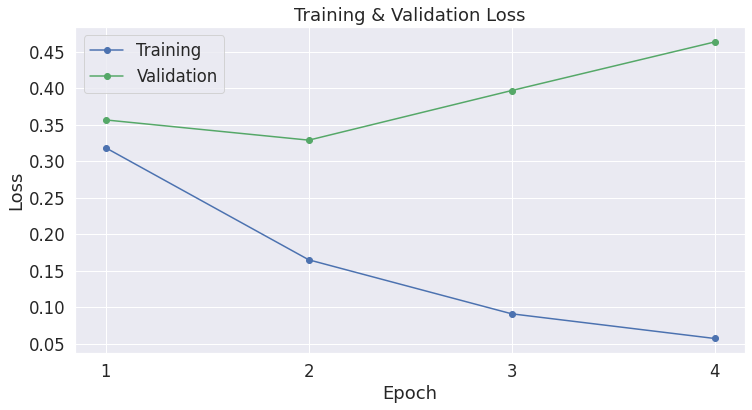

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("data/twitter-2016test-BD.txt", delimiter='\t', header=None, names=['topic','label','tweet','id'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists

test_tweet = df.tweet.values
test_topic = df.topic.values
y_test = df.label.values

test_labels=[]
label_dict = {'negative':0,'positive':1}

for label in y_test:
  test_labels.append(label_dict[label])


Number of test sentences: 10,551



In [ ]:
input_ids,attention_masks,token_type_ids,labels = processdata(test_topic,test_tweet,test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks,token_type_ids,labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def test(model,prediction_dataloader): 

  total_test_acc  = 0
  total_F1_Score = 0
  total_precision = 0
  total_recall = 0

  for batch_idx, (pair_token_ids, mask_ids,token_type_ids,y) in enumerate(prediction_dataloader):
    pair_token_ids = pair_token_ids.to(device)
    mask_ids = mask_ids.to(device)
    labels = y.to(device)
    token_type_ids=token_type_ids.to(device)

    loss, prediction = model(pair_token_ids, 
                             token_type_ids=token_type_ids, 
                             attention_mask=mask_ids, 
                             labels=labels).values()


    acc = accuracy(prediction, labels)

    f1 = metrics.f1_score(labels.cpu(), torch.argmax(prediction, -1).cpu(), average='binary')
    precision = precision_score(labels.cpu(), torch.argmax(prediction, -1).cpu(), average="binary")
    recall = recall_score(labels.cpu(), torch.argmax(prediction, -1).cpu(), average="binary")

    total_test_acc  += acc.item()
    total_F1_Score += f1
    total_precision += precision
    total_recall += recall
  
  test_acc  = total_test_acc/len(prediction_dataloader)
  test_f1 = total_F1_Score/len(prediction_dataloader)
  test_precision = total_precision/len(prediction_dataloader)
  test_recall = total_recall/len(prediction_dataloader)


  print(f'test_acc: {test_acc:.4f}')
  print(f'f1 Score: {test_f1:.4f}')
  print(f'precision: {test_precision:.4f}')
  print(f'recall: {test_recall:.4f}')

In [ ]:
test(model,prediction_dataloader)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


test_acc: 0.8969
f1 Score: 0.8484
precision: 0.8381
recall: 0.8882
